# NYC Taxi Ride Clustering to Enhance Carpool Efficiency

## Date: 12/10/2019

In this project, yellow cab trip data in Manhattan region has been analyzed. One week of the trip data is utlized and two different ways of clustering using different features is employed. Their efficiency in passenger and trip reduction  is compared at different time of the day. Further, prime locations for high efficiency carpooling are identified and visualized

For best results please use [NBViewer](https://nbviewer.jupyter.org/github/swami84/NYC-Yellow-Cab-Clustering-for-Carpool/blob/master/NYC_Carpool_Clustering%20Analysis.ipynb?flush_cache=true) to see the notebook. 

In [1]:
# Importing important libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import json
import folium
from folium.plugins import HeatMapWithTime
from folium.plugins import HeatMap
import os.path
from os import path
import matplotlib.cm as cm
import warnings
from matplotlib.ticker import MultipleLocator
warnings.filterwarnings('ignore')
from time import perf_counter
from sklearn.cluster import KMeans

In [2]:
def save_fig(name):
    dpath = './Images/'
    os.makedirs(dpath, exist_ok=True)
    filename = dpath + name + '.jpg'
    plt.savefig(filename, bbox_inches = 'tight')

In [3]:
# Setting Seaborn graph style
sns.set(font_scale=2)
sns.set_style("whitegrid")
sns.set_context("poster", rc={'grid.color': 'black', "grid.linewidth": 2, 'lines.markersize':15})

In [4]:
def filter_df(df,  startdate, enddate):
    df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'],format='%Y-%m-%d %H:%M:%S', errors='coerce')
    df = df.loc[(df['tpep_pickup_datetime'] >= startdate)& (df['tpep_pickup_datetime'] < enddate)]
    return df

In [5]:
def parse_timestamp(df, freq='5 min'):
    
    df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'],format='%Y-%m-%d %H:%M:%S', errors='coerce')
    df['Timestamp'] = pd.to_datetime(df['tpep_pickup_datetime'].dt.round(freq = freq))
    
    df['Date'] = (df['Timestamp']).dt.date
    df['Time'] = (df['Timestamp']).dt.time
    df['Day'] = df['tpep_pickup_datetime'].dt.strftime('%A')
    
    return df

In [6]:
def process_df(df):
    #Keeping only the columns required
    df = df[['pickup_latitude' ,'pickup_longitude','dropoff_latitude' , 
             'dropoff_longitude','tpep_pickup_datetime','total_amount' , 
             'passenger_count' ,'Date', 'Time','total_amount','Day' ]].copy()
    
    # Removing all zero entries
    df = df[(df != 0).all(1)]
    
    # Removing all passengers 5 and above
    df = df.loc[(df['passenger_count']>0) & (df['passenger_count']<5)]
    df = df.sort_values(by='tpep_pickup_datetime',kind='heapsort', ascending=True)
    
    df = df.round(4)    

    df = df.dropna()
    df = df.reset_index(drop=True)
    return df

### Data Source - https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2016-06.csv
The dataset was downloaded locally

In [7]:
start_date = pd.to_datetime("2016-06-06").date()
end_date = pd.to_datetime("2016-06-13").date()

fpath = "./Data/Pickled Data/YC_2016_Jun_Wk1_Prep.pkl"
if path.exists(fpath):
    yc_2016_jun_wk1_prep = pd.read_pickle(fpath)
else:
    trips_yc_2016_june = pd.read_csv('./Data/trip_data/yellow_tripdata_2016-06.csv', low_memory=False)
    yc_2016_jun_wk1_raw = filter_df(trips_yc_2016_june, start_date, end_date)
    yc_2016_jun_wk1_prep = process_df(parse_timestamp(yc_2016_jun_wk1_raw))
    
    dpath ='./Data/Pickled Data/'
    os.makedirs(dpath, exist_ok=True) 
    yc_2016_jun_wk1_prep.to_pickle(fpath)
yc_2016_jun_wk1_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2019695 entries, 0 to 2019694
Data columns (total 11 columns):
pickup_latitude         float64
pickup_longitude        float64
dropoff_latitude        float64
dropoff_longitude       float64
tpep_pickup_datetime    datetime64[ns]
total_amount            float64
passenger_count         int64
Date                    object
Time                    object
total_amount            float64
Day                     object
dtypes: datetime64[ns](1), float64(6), int64(1), object(3)
memory usage: 169.5+ MB


In [8]:
yc_2016_jun_wk1_prep.head()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,tpep_pickup_datetime,total_amount,passenger_count,Date,Time,total_amount,Day
0,40.7506,-73.9787,40.7250,-73.9971,2016-06-06 00:00:00,13.35,1,2016-06-06,00:00:00,13.35,Monday
1,40.7851,-73.9465,40.8077,-73.9239,2016-06-06 00:00:00,21.30,1,2016-06-06,00:00:00,21.30,Monday
2,40.7415,-73.9524,40.7209,-74.0041,2016-06-06 00:00:00,58.34,1,2016-06-06,00:00:00,58.34,Monday
3,40.7422,-73.9807,40.7590,-73.9678,2016-06-06 00:00:01,9.12,2,2016-06-06,00:00:00,9.12,Monday
4,40.7563,-73.9868,40.7631,-73.9761,2016-06-06 00:00:02,6.30,1,2016-06-06,00:00:00,6.30,Monday


### Let us look at the trips with single passengers

In [9]:
pass_count  = yc_2016_jun_wk1_prep.groupby('passenger_count').size().reset_index()
pass_count = pass_count.rename(columns={0: 'Trip Count'})
pass_count['Percentage of Trips'] = pass_count['Trip Count']*100/pass_count['Trip Count'].sum()
pass_count = pass_count.round(2)
pass_count

,passenger_count,Trip Count,Percentage of Trips
0,1,1570057,77.74
1,2,315689,15.63
2,3,91425,4.53
3,4,42524,2.11


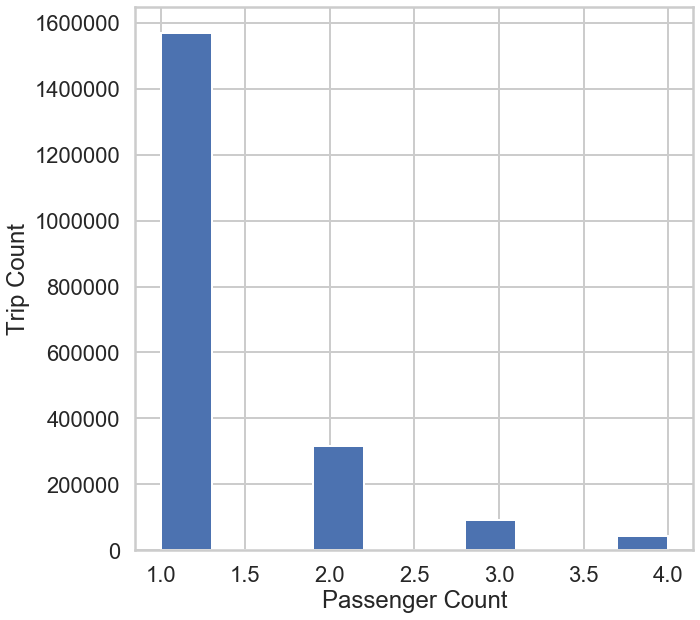

In [10]:
fig = plt.figure(figsize= (10,10))
yc_2016_jun_wk1_prep['passenger_count'].hist()
plt.xlabel('Passenger Count')
plt.ylabel('Trip Count')
save_fig('Passenger Count per Trip Distribution')


In [11]:
# Calculate bearing angle from the pickup to dropoff

def get_bearing(long1, lat1, long2, lat2): 
    long1, lat1, long2, lat2 = map(np.radians, [long1, lat1, long2, lat2])
    bearing = np.arctan2(np.sin(long2-long1)*np.cos(lat2), np.cos(lat1)*np.sin(lat2)-np.sin(lat1)*np.cos(lat2)*np.cos(long2-long1))
    bearing = np.degrees(bearing)
    bearing = (bearing + 360) % 360
    
    return np.round(bearing,2)

# Calculate haversine distance from the pickup to dropoff

def haversine_np(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    distance = 3958.8 * c
    return np.round(distance,2)

In [12]:
# Calculating the Bearing angle and Haversine Distance
# Dividing each feature by 1000 to ensure lower weightage when clustering

yc_2016_jun_wk1_prep['Dropoff Bearing Angle'] = get_bearing( yc_2016_jun_wk1_prep['pickup_longitude'],
                                                            yc_2016_jun_wk1_prep['pickup_latitude'],
                                                            yc_2016_jun_wk1_prep['dropoff_longitude'],  
                                                            yc_2016_jun_wk1_prep['dropoff_latitude'])/1000

yc_2016_jun_wk1_prep['Pickup Bearing Angle'] = get_bearing( yc_2016_jun_wk1_prep['dropoff_longitude'],  
                                                            yc_2016_jun_wk1_prep['dropoff_latitude'],
                                                            yc_2016_jun_wk1_prep['pickup_longitude'],
                                                            yc_2016_jun_wk1_prep['pickup_latitude'])/1000
    
yc_2016_jun_wk1_prep['Distance'] = haversine_np(    yc_2016_jun_wk1_prep['pickup_longitude'],
                                                                       yc_2016_jun_wk1_prep['pickup_latitude'],
                                                                       yc_2016_jun_wk1_prep['dropoff_longitude'],  
                                                                       yc_2016_jun_wk1_prep['dropoff_latitude'])/1000

yc_2016_jun_wk1_prep.head()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,tpep_pickup_datetime,total_amount,passenger_count,Date,Time,total_amount,Day,Dropoff Bearing Angle,Pickup Bearing Angle,Distance
0,40.7506,-73.9787,40.7250,-73.9971,2016-06-06 00:00:00,13.35,1,2016-06-06,00:00:00,13.35,Monday,0.20858,0.02857,0.00201
1,40.7851,-73.9465,40.8077,-73.9239,2016-06-06 00:00:00,21.30,1,2016-06-06,00:00:00,21.30,Monday,0.03712,0.21713,0.00196
2,40.7415,-73.9524,40.7209,-74.0041,2016-06-06 00:00:00,58.34,1,2016-06-06,00:00:00,58.34,Monday,0.24228,0.06225,0.00306
3,40.7422,-73.9807,40.7590,-73.9678,2016-06-06 00:00:01,9.12,2,2016-06-06,00:00:00,9.12,Monday,0.03018,0.21019,0.00134
4,40.7563,-73.9868,40.7631,-73.9761,2016-06-06 00:00:02,6.30,1,2016-06-06,00:00:00,6.30,Monday,0.05000,0.23001,0.00073


In [13]:
# Assign NY  borough based on lat,long of pickup and dropoff and filter data for only Manhattan pickup and dropoffs

import geopandas
from osgeo import ogr, gdal
from geopandas.tools import sjoin
def filter_boro_neigh(df):
    geometry=geopandas.points_from_xy(df['pickup_longitude'], df['pickup_latitude'])
    point = geopandas.GeoDataFrame(df,geometry = geometry )
    poly  = geopandas.GeoDataFrame.from_file('./Boundaries/NYC_NH.shp')
    df_boro = sjoin(point, poly, how='left')
    geometry=geopandas.points_from_xy(df_boro['dropoff_longitude'], df['dropoff_latitude'])
    df_boro = df_boro.drop(columns=['index_right'])
    point = geopandas.GeoDataFrame(df_boro,geometry = geometry )
    poly  = geopandas.GeoDataFrame.from_file('./Boundaries/NYC_NH.shp')
    df_boro = sjoin(point, poly, how='left',)
    df['Pickup Boro'] = df_boro['boro_name_left']
    df['Dropoff Boro'] = df_boro['boro_name_right']
    df['Pickup Neighborhood'] = df_boro['ntaname_left']
    df['Dropoff Neighborhood'] = df_boro['ntaname_right']
    df = df.loc[(df['Pickup Boro']=='Manhattan') & (df['Dropoff Boro']=='Manhattan')]
    return df

In [14]:
from os import path

fpath = "./Data/Pickled Data/YC_2016_Jun_Wk1_Processed_Manhattan.pkl"
if path.exists(fpath):
    trips_processed = pd.read_pickle(fpath)
else:
    trips_processed = filter_boro_neigh(yc_2016_jun_wk1_prep)
    os.makedirs(dpath, exist_ok=True) 
    dpath ='./Data/Pickled Data/'
    trips_processed.to_pickle(dpath + 'YC_2016_Jun_Wk1_Processed_Manhattan.pkl')

trips_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1898063 entries, 0 to 2019692
Data columns (total 19 columns):
pickup_latitude          float64
pickup_longitude         float64
dropoff_latitude         float64
dropoff_longitude        float64
tpep_pickup_datetime     datetime64[ns]
total_amount             float64
passenger_count          int64
Date                     object
Time                     object
total_amount             float64
Day                      object
Dropoff Bearing Angle    float64
Pickup Bearing Angle     float64
Distance                 float64
geometry                 geometry
Pickup Boro              object
Dropoff Boro             object
Pickup Neighborhood      object
Dropoff Neighborhood     object
dtypes: datetime64[ns](1), float64(9), geometry(1), int64(1), object(7)
memory usage: 289.6+ MB


In [15]:
# Grouping trips by Day and Time
trips_processed['Hour'] = pd.to_datetime(trips_processed['Time'],format='%H:%M:%S').dt.hour

trips_grp_by_day_time = trips_processed.groupby(["Day","Time"]).size()
trips_grp_by_day_time= trips_grp_by_day_time.reset_index()

trips_grp_by_day_time = trips_grp_by_day_time.rename(columns={0:'Total Trips'})


In [16]:
# Calculates the pickup and dropoff distances and averages for the top 5 cluster counts
def mean_pickup_dropoff_dist(df_train,kmeans):
    cl_count = df_train['cluster'].value_counts()
    cl_count= cl_count.reset_index()
    cl_count = cl_count.rename(columns={'index': 'Cluster_Label', 'cluster': 'Count'})
    mean_pickup_distance = 0
    mean_dropoff_distance = 0
    cl_range = 5
    if cl_count['Cluster_Label'].nunique() <5:
        cl_range = cl_count['Cluster_Label'].nunique()
    for i in range(cl_range):
        max_cluster = cl_count['Cluster_Label'][i]
        df_max_cluster = df_train.loc[df_train['cluster']==max_cluster]
        
        pu_cent_lat = (kmeans.cluster_centers_[max_cluster])[0]
        pu_cent_long = (kmeans.cluster_centers_[max_cluster])[1]
        do_cent_lat = (kmeans.cluster_centers_[max_cluster])[2]
        do_cent_long = (kmeans.cluster_centers_[max_cluster])[3]

        df_max_cluster['Pickup_Dist_from_Centroid'] = haversine_np(pu_cent_long,pu_cent_lat,
                                                                       df_max_cluster['pickup_longitude'],  
                                                                       df_max_cluster['pickup_latitude'] )

        df_max_cluster['Dropoff_Dist_from_Centroid'] = haversine_np(do_cent_long,do_cent_lat,
                                                                       df_max_cluster['dropoff_longitude'],  
                                                                       df_max_cluster['dropoff_latitude'] )
        
        mean_pickup_distance +=df_max_cluster['Pickup_Dist_from_Centroid'].mean()
        mean_dropoff_distance +=df_max_cluster['Dropoff_Dist_from_Centroid'].mean()

    return mean_pickup_distance/5, mean_dropoff_distance/5


### Now let us estimate the distortion needed to choose the number of clusters
* We run k-means with different cluster sizes and record the distortion, size of dataframe and Mean
* We use the size and distance info to predict distortion using a Random Forest Regressor

In [17]:
# Assign empty lists that will be appended at each clustering run


def cluster_dist_size_feat(df, feat_list):
    size,dist,distortions = [],[],[]
    
    for i in range (0, len(df)):
        df_train = trips_processed.loc[(trips_processed['Time']==df['Time'][i]) 
                                          &(trips_processed['Day']==df['Day'][i])]

        step_size = int(np.ceil(len(df_train)/10))
        train = df_train[feat_list].copy()
        
        min = int(len(train)/10)
        max = int(len(train)/1.5)
        if len(train)<300:
            max = int(len(train))
        if len(train)>10000:
            max = int(len(train)/5)
        for n in range(min,max,step_size):
            
            kmeans = KMeans(n_clusters=n,n_jobs=-1, random_state=0).fit(train)
            df_train['cluster'] = kmeans.labels_
            distortions.append(kmeans.inertia_)
            cluster_ratio.append(n/len(train))
            pu, do = mean_pickup_dropoff_dist(df_train,kmeans)
            dist.append((pu+do)/2)
            size.append(len(train))
    return size, distortions, dist



In [18]:
def split_df_get_data(df_main,frac=0.05):
    df = df_main.sample(frac=frac)
    df = df.reset_index(drop=True)
    feat_list = ['pickup_latitude', 'pickup_longitude','dropoff_latitude', 'dropoff_longitude' ]
    size, distortions, dist = cluster_dist_size_feat(df,feat_list)
    return size, distortions, dist

In [19]:
def run_distortion_predition(size, distortions, dist):
    from sklearn.ensemble import RandomForestRegressor
    X = np.column_stack([dist, size])
    distortion_pred = RandomForestRegressor()
    distortion_pred.fit(X,distortions)
    return distortion_pred

In [20]:
import pickle
dpath = './Models/'
fname = 'distortion_pred_model'
fpath = dpath+fname
if path.exists(fpath):
    distortion_pred = pickle.load(open(fpath,'rb'))
    df = pd.read_pickle(dpath+ 'df_distortion_pred.pkl')
    size, distortions, dist = df['Size'].values, df['Distortions'].values, df['Distance'].values
else:
    size, distortions, dist = split_df_get_data(trips_grp_by_day_time,frac=0.05)
    df_distortion_pred = pd.DataFrame(  {'Size': size,
                                         'Distortions': distortions,
                                         'Distance': dist
                                        })
    
    df_distortion_pred.to_pickle(dpath+'df_distortion_pred.pkl')
    distortion_pred = run_distortion_predition (size, distortions, dist)
    os.makedirs(dpath, exist_ok=True)
    pickle.dump(distortion_pred,open(fpath,'wb'))
    


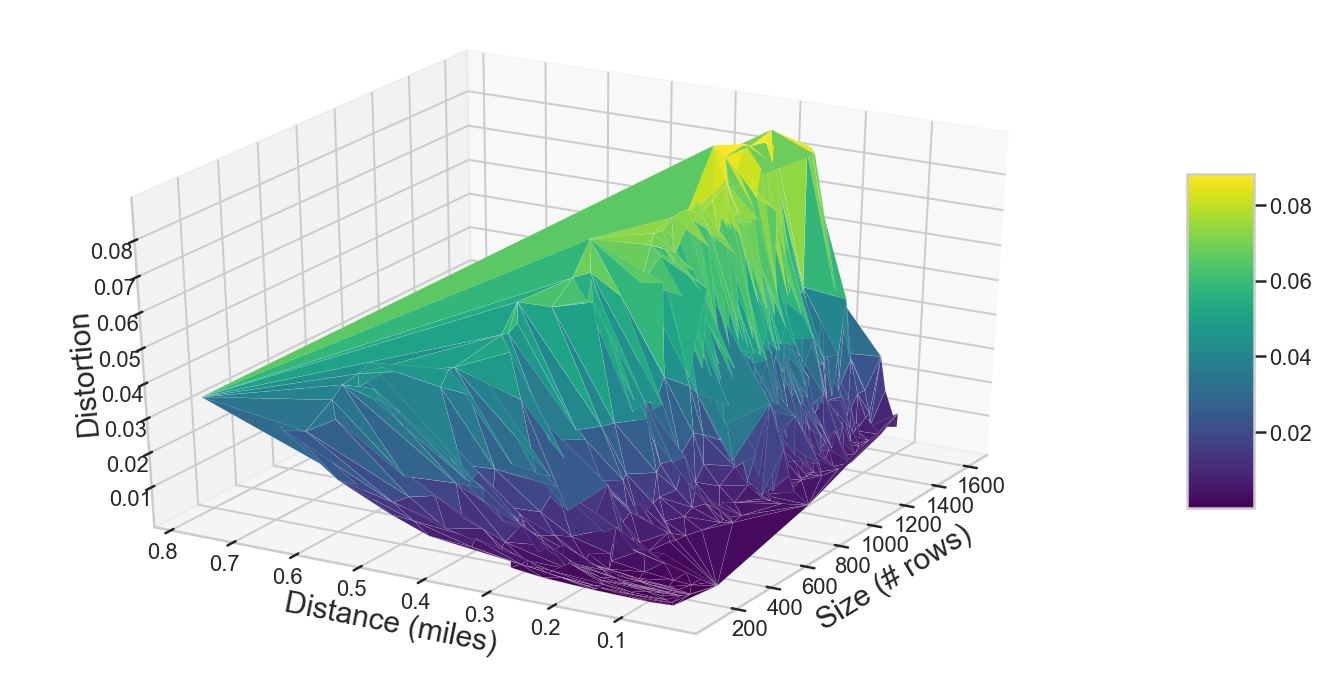

In [21]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(20,10))
ax = fig.gca(projection='3d')
surf = ax.plot_trisurf(size,  dist ,distortions, cmap=plt.cm.viridis, linewidth=0.1,alpha=1,antialiased=True)

fig.colorbar( surf, shrink=0.5, aspect=5)
ax.set_xlabel(r'Size (# rows)', fontsize=30, rotation=30, labelpad=20)
ax.set_ylabel(r'Distance (miles)', fontsize=30, rotation=30, labelpad=20)
ax.zaxis.set_rotate_label(False)
ax.set_zlabel(r'Distortion', fontsize=30,rotation = 95,labelpad=10)

ax.view_init(30,210)
fig.tight_layout()

save_fig('3D Surface plot_Size_Distance_Distortion')

Text(0, 0.5, 'Dstortion')

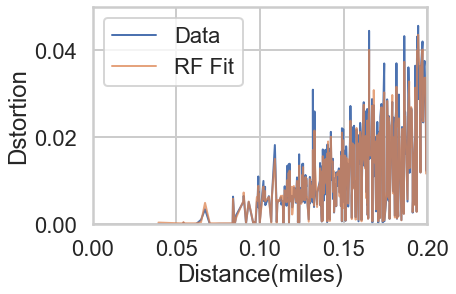

In [22]:
X = np.column_stack([dist, size])
rf_fit = distortion_pred.predict(X)
sns.lineplot(x=dist, y =distortions, linewidth=2,alpha = 1, label='Data')
sns.lineplot(x=dist, y =rf_fit, linewidth=2,alpha = 0.75, label = 'RF Fit')
plt.xlim(0,0.2)
plt.ylim(0,0.05)

plt.xlabel('Distance(miles)')
plt.ylabel('Dstortion')


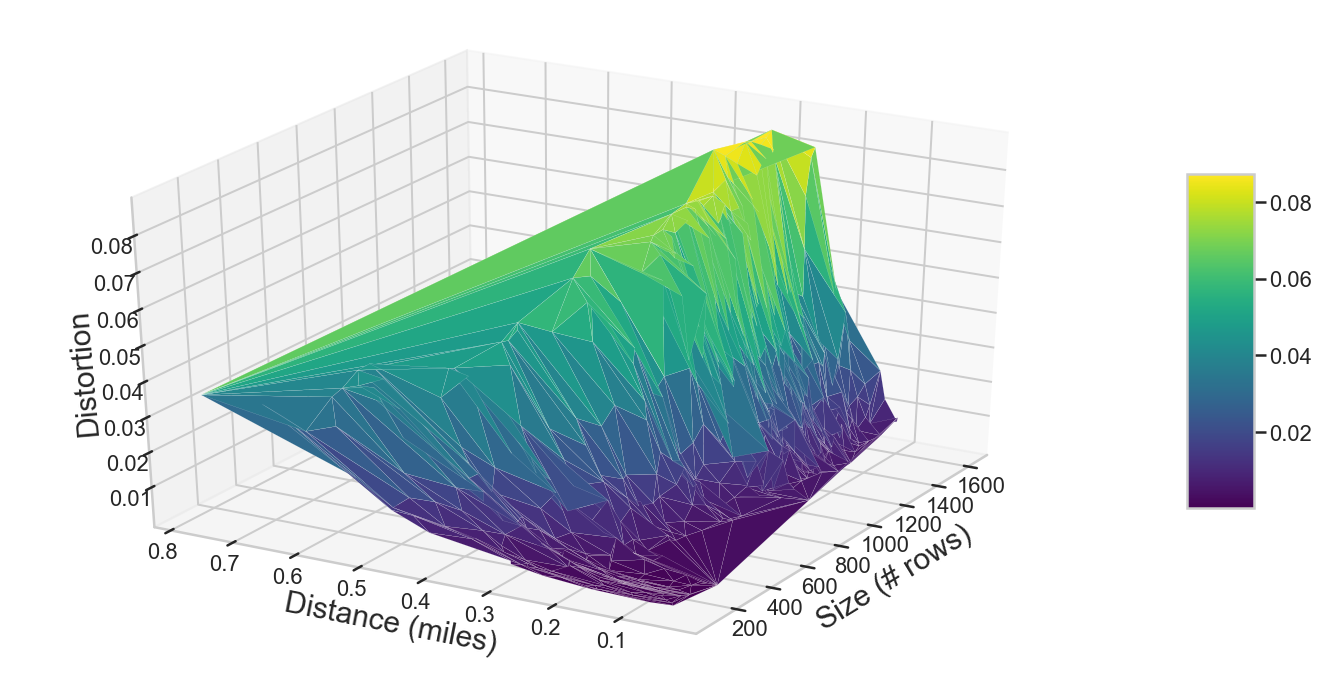

In [23]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(20,10))
ax = fig.gca(projection='3d')
surf = ax.plot_trisurf(size,  dist ,rf_fit, cmap=plt.cm.viridis, linewidth=0.1,alpha=1,antialiased=True)

fig.colorbar( surf, shrink=0.5, aspect=5)
ax.set_xlabel(r'Size (# rows)', fontsize=30, rotation=30, labelpad=20)
ax.set_ylabel(r'Distance (miles)', fontsize=30, rotation=30, labelpad=20)
ax.zaxis.set_rotate_label(False)
ax.set_zlabel(r'Distortion', fontsize=30,rotation = 95,labelpad=10)

ax.view_init(30,210)
fig.tight_layout()

save_fig('3D Surface plot_Size_Distance_Distortion_fit')

In [24]:
# Predict distortion for mean pickup distance ~ 0.05 miles and df size of 100
x_pred = np.array([0.1, 1000])
print(distortion_pred.predict(x_pred.reshape(1,-1))[0])

0.006114617347811988


## Algorithm
 * Aggregation using K-Means clustering using 2 different lists of features
    * Method 1: Using pickup location (lat,long) and drop-off location (lat,long)
    * Method 2: Using pickup location (lat,long) and drop-off bearing angle and distance


## Efficiency


\begin{equation*}
Single\ Ride  \ Eff = \frac {\Bigl(Single \ Rides_{initial} - Single \ Rides_{cluster}\Bigr)} { \ Single \ Rides_{initial}} \times \ 100
\end{equation*}

\begin{equation*}
Overall\ Ride  \ Eff = \frac {\Bigl(Total \ Rides_{initial} - Total \ Rides_{cluster}\Bigr)} { \ Total \ Rides_{initial}} \times \ 100
\end{equation*}

\begin{equation*}
Passenger\  Eff = \frac {\Bigl(Passengers \ Per \ Car_{cluster} - Passenger \ Per \ Car_{initial}\Bigr)} { Passengers \ Per \ Car_{cluster} } \times \ 100
\end{equation*}

In [25]:
from sklearn.cluster import KMeans
def kmeans_cluster(df_train,feat_list):
    
    train = df_train[feat_list].copy()
    x_pred = np.array([0.05, len(train)])
    distortion = distortion_pred.predict(x_pred.reshape(1,-1))[0]
    
    step_size = int(np.ceil(len(train)/10))
    min = int(len(train)/10)
    max = len(train)
    
    for n in range(min,max,step_size):
            
        kmeans = KMeans(n_clusters=n,n_jobs=-1, random_state=0).fit(train)
        if (kmeans.inertia_< distortion):
            break
        

    df_train['cluster'] = kmeans.labels_
    return df_train, kmeans

In [26]:
def get_mean_pu_do_dist(agg_df,df_train):
    mean_pickup_distance = []
    mean_dropoff_distance = []

    cl_range = agg_df['cluster'].nunique()
    for i in range(cl_range):
        cluster = agg_df['cluster'][i]
        df_cluster = df_train.loc[df_train['cluster']==cluster]

        pu_cent_lat = (model.cluster_centers_[cluster])[0]
        pu_cent_long = (model.cluster_centers_[cluster])[1]
        do_cent_lat = (model.cluster_centers_[cluster])[2]
        do_cent_long = (model.cluster_centers_[cluster])[3]

        pu_dist= haversine_np(pu_cent_long,pu_cent_lat,
                               df_cluster['pickup_longitude'],
                               df_cluster['pickup_latitude'] )

        do_dist = haversine_np(do_cent_long,do_cent_lat,
                               df_cluster['dropoff_longitude'],
                               df_cluster['dropoff_latitude'] )


        mean_pickup_distance.append(pu_dist.mean())
        mean_dropoff_distance.append(do_dist.mean())
    return mean_pickup_distance,mean_dropoff_distance

In [27]:
def summ_df(df,model):
    
    agg_df= df.groupby(['cluster'])['passenger_count'].agg(['sum'])
    agg_df['Count']= df.groupby(['cluster'])['passenger_count'].agg(['count'])
    
    agg_df ['Pickup Centroid Latitude'] = model.cluster_centers_[:,0]
    agg_df ['Pickup Centroid Longitude'] = model.cluster_centers_[:,1]
    agg_df ['Dropoff Centroid Latitude'] = model.cluster_centers_[:,2]
    agg_df ['Dropoff Centroid Longitude'] = model.cluster_centers_[:,3]
    
    agg_df['trips'] = np.ceil(agg_df['sum']/4)
    base_pass_per_car = agg_df['sum']/agg_df['Count']
    clust_pass_per_car = agg_df['sum']/agg_df['trips']
    agg_df['Passenger Efficiency'] = (clust_pass_per_car-base_pass_per_car)*100/clust_pass_per_car
    agg_df['Time'] = df_train['Time'].iloc[0]
    agg_df['Day'] = df_train['Day'].iloc[0]
    agg_df = agg_df.reset_index()
    
    agg_df['Mean Pickup Distance'],agg_df['Mean Dropoff Distance'] = get_mean_pu_do_dist(agg_df, df)
   
    
    return agg_df

In [28]:
def run_clustering(df_main,df_group,feat_list,i):
    df_train = df_main.loc[(df_main['Time']==df_group['Time'][i]) & (df_main['Day']==df_group['Day'][i])]
    df_train, model = kmeans_cluster(df_train,feat_list)
    return df_train,model

### Now lets visualize how each method clusters the pickups and dropoffs

In [29]:
nyc_coor = [40.770, -73.9654]

# Creates base map of NYC
def generateBaseMap(default_location=nyc_coor, default_zoom_start=8.5):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

In [30]:
def generate_map(method,df,kmeans_model):
    colors =     ['red', 'blue', 'green', 'purple', 'orange', 'darkred',
                  'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue',
                  'darkpurple', 'pink', 'lightblue', 'lightgreen',
                  'gray', 'black', 'lightgray']
    base_map = generateBaseMap(default_zoom_start=12.5)
    for i in range(5):
        
        cl_count = df['cluster'].value_counts()
        cl_count= cl_count.reset_index()
        cl_count = cl_count.rename(columns={'index': 'Cluster_Label', 'cluster': 'Count'})
        max_cluster = cl_count['Cluster_Label'][i]
        
        df_max_cluster = df.loc[df['cluster']==max_cluster]
        list_pu = df_max_cluster[['pickup_latitude', 'pickup_longitude']].values.tolist()
        list_do = df_max_cluster[['dropoff_latitude', 'dropoff_longitude']].values.tolist()
        
        for location in list_pu:
            folium.Marker(location,icon=folium.Icon(color=colors[i], icon='info-sign')).add_to(base_map)
        for location in list_do:
            folium.Marker(location,icon=folium.Icon(color=colors[i], icon='star')).add_to(base_map)

        folium.Marker(kmeans_model.cluster_centers_[max_cluster][:2],
                      icon=folium.Icon(color=colors[i], icon = 'home')).add_to(base_map)
        folium.Marker(kmeans_model.cluster_centers_[max_cluster][2:4],
                      icon=folium.Icon(color=colors[i], icon = 'flag')).add_to(base_map)
        
    dpath ='./HTML/'
    os.makedirs(dpath, exist_ok=True) 
    fname = dpath + method + '_Cluster_Map_' + '.html'
    base_map.save(fname)

In [31]:
max_index = trips_grp_by_day_time.index[trips_grp_by_day_time['Total Trips'] == trips_grp_by_day_time['Total Trips'].max()][0]
min_index = trips_grp_by_day_time.index[trips_grp_by_day_time['Total Trips'] == trips_grp_by_day_time['Total Trips'].min()][0]

fl_m1 =  ['pickup_latitude' ,'pickup_longitude','dropoff_latitude' , 'dropoff_longitude']

df_train, model = run_clustering(trips_processed,trips_grp_by_day_time,fl_m1,max_index)
generate_map('method1_max',df_train,model)

df_train, model = run_clustering(trips_processed,trips_grp_by_day_time,fl_m1,min_index)
generate_map('method1_min',df_train,model)

fl_m2 = ['pickup_latitude', 'pickup_longitude','Dropoff Bearing Angle', 'Distance' ]

df_train, model = run_clustering(trips_processed,trips_grp_by_day_time,fl_m2,max_index)
generate_map('method2_max',df_train,model)

df_train, model = run_clustering(trips_processed,trips_grp_by_day_time,fl_m2,min_index)
generate_map('method2_min',df_train,model)

## Method 1 Max Cluster Map

In [32]:
from IPython.display import IFrame
IFrame(src='./HTML/method1_max_Cluster_Map_.html', width=900, height=1000)

## Method 2 Max Cluster Map

In [33]:
IFrame(src='./HTML/method2_max_Cluster_Map_.html', width=900, height=1000)

## Method 1 Min Cluster Map

In [34]:
IFrame(src='./HTML/method1_min_Cluster_Map_.html', width=900, height=1000)

## Method 2 Min Cluster Map

In [35]:
IFrame(src='./HTML/method2_min_Cluster_Map_.html', width=900, height=1000)

In [36]:
fname1='./Data/Pickled Data/Cluster_DF_day_time_Method1.pkl'
fname2='./Data/Pickled Data/Cluster_DF_day_time_Method2.pkl'

if path.exists(fname1) and  path.exists(fname2):
    clust_df_day_time_method1 = pd.read_pickle(fname1)
    clust_df_day_time_method2 = pd.read_pickle(fname2)
else:
    clust_df_day_time_method1=pd.DataFrame()
    clust_df_day_time_method2=pd.DataFrame()
    for i in range(len(trips_grp_by_day_time)):
        
        fl_m1 =  ['pickup_latitude' ,'pickup_longitude','dropoff_latitude' , 'dropoff_longitude']
        df_train, model = run_clustering(trips_processed,trips_grp_by_day_time,fl_m1,i)
        clust_df_day_time_method1 = pd.concat([clust_df_day_time_method1, summ_df(df_train,model)])
        
        fl_m2 = ['pickup_latitude', 'pickup_longitude','Dropoff Bearing Angle', 'Distance' ]
        df_train, model = run_clustering(trips_processed,trips_grp_by_day_time,fl_m2,i)
        clust_df_day_time_method2 = pd.concat([clust_df_day_time_method2, summ_df(df_train,model)])

        if i==0:
            tic = perf_counter()

        if (i+1)%100==0:
            toc = perf_counter()
            print('Processed ',i+1,'Rows in ', toc-tic, 'seconds')
            clust_df_day_time_method1.to_pickle(fname1)
            clust_df_day_time_method2.to_pickle(fname2)
            tic = perf_counter()
        
clust_df_day_time_method1.to_pickle(fname1)
clust_df_day_time_method2.to_pickle(fname2)


In [37]:
print(len(clust_df_day_time_method1))
print(len(clust_df_day_time_method2))

1265955
1149666


In [38]:
# Ordering the days from Monday to Sunday
cat_day = ['Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday', 'Saturday', 'Sunday']
clust_df_day_time_method1['Day'] = pd.Categorical(clust_df_day_time_method1['Day'], ordered=True, categories=cat_day)
clust_df_day_time_method2['Day'] = pd.Categorical(clust_df_day_time_method2['Day'], ordered=True, categories=cat_day)

# Adding hours to df

clust_df_day_time_method1['Hour'] = pd.to_datetime(clust_df_day_time_method1['Time'],format='%H:%M:%S').dt.hour
clust_df_day_time_method2['Hour'] = pd.to_datetime(clust_df_day_time_method2['Time'],format='%H:%M:%S').dt.hour

In [39]:
df1 = clust_df_day_time_method1.sample(frac=1)
df2 = clust_df_day_time_method2.sample(frac=1)

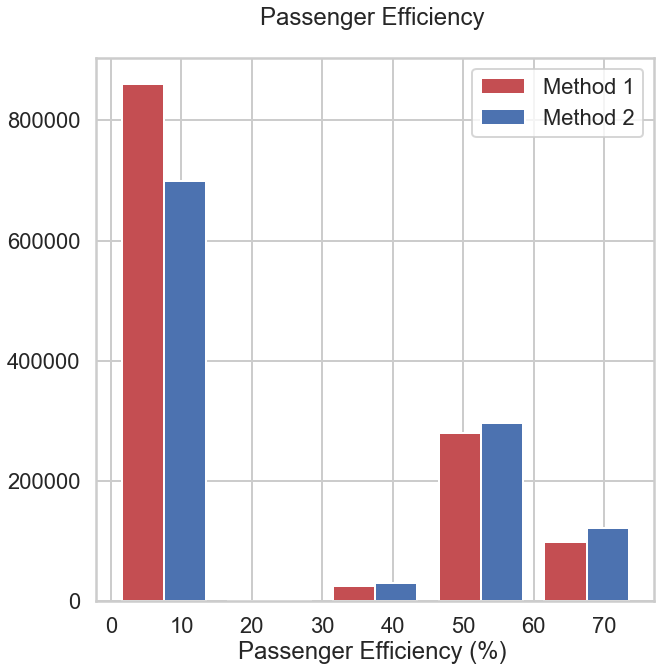

In [40]:
figure = plt.figure(figsize=(10,10))
plt.hist([df1['Passenger Efficiency'], df2['Passenger Efficiency']],bins=5, color=['r','b'],label=['Method 1','Method 2'])
plt.title('Passenger Efficiency \n')
plt.xlabel('Passenger Efficiency (%) ')

plt.legend(loc='upper right')
save_fig('Passenger Efficiency')

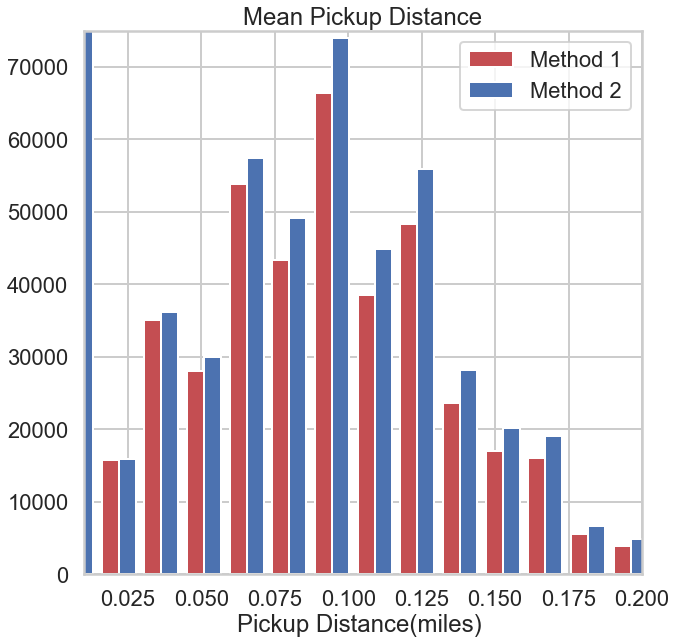

In [41]:
figure = plt.figure(figsize=(10,10))
plt.hist([df1['Mean Pickup Distance'], df2['Mean Pickup Distance']],bins=25, 
         color=['r','b'],label=['Method 1','Method 2'])
plt.title('Mean Pickup Distance')
plt.xlabel('Pickup Distance(miles) ')
plt.xlim(0.01,0.2)
plt.legend(loc='upper right')
plt.ylim(0,75000)
save_fig('Pickup Distance Histogram')

In [42]:
centroids_PU_time_list_m1 = []
day_time_m1  = df1[['Day', 'Hour']].groupby(['Day', 'Hour']).count().reset_index().values.tolist()
for Day, Hour in day_time_m1:
    centroids_PU_time_list_m1.append(df1.loc[(df1.Hour == Hour) & (df1.Day == Day), \
                                ['Pickup Centroid Latitude', 'Pickup Centroid Longitude','Passenger Efficiency']] \
                                  .groupby(['Pickup Centroid Latitude','Pickup Centroid Longitude']) \
                                  .mean().reset_index().values.tolist())
index = []
for i in range(len(day_time_m1)):
    index.append(str(day_time_m1[i][0]) + ' '+  str(day_time_m1[i][1])+ ' Hours')
    
gradient_map={0.1: 'blue', 0.5: 'lime', 0.7: 'green', 0.8: 'yellow', 0.95: 'orange', 1: 'red'}
base_map = generateBaseMap(default_zoom_start=13)
HeatMapWithTime(centroids_PU_time_list_m1, radius=10,gradient = gradient_map,
                min_opacity=0.75, max_opacity=0.95,index=index, use_local_extrema=False, min_speed=1,
                max_speed=10,overlay=False, auto_play=True,speed_step=1,
                scale_radius=False, position='topleft').add_to(base_map)

base_map.save('./HTML/Pickup_Centroid_Method1.html')
IFrame(src='./HTML/Pickup_Centroid_Method1.html', width=900, height=1000)

In [43]:
centroids_PU_time_list_m2 = []
day_time_m2  = df2[['Day', 'Hour']].groupby(['Day', 'Hour']).count().reset_index().values.tolist()
for Day, Hour in day_time_m2:
    centroids_PU_time_list_m2.append(df1.loc[(df1.Hour == Hour) & (df1.Day == Day), \
                                ['Pickup Centroid Latitude', 'Pickup Centroid Longitude','Passenger Efficiency']] \
                                  .groupby(['Pickup Centroid Latitude','Pickup Centroid Longitude']) \
                                  .mean().reset_index().values.tolist())
index = []
for i in range(len(day_time_m2)):
    index.append(str(day_time_m2[i][0]) + ' '+  str(day_time_m2[i][1])+ ' Hours')
    
gradient_map={0.1: 'blue', 0.3: 'lime', 0.7: 'green', 0.8: 'yellow', 0.95: 'orange', 1: 'red'}
base_map = generateBaseMap(default_zoom_start=13)
HeatMapWithTime(centroids_PU_time_list_m2, radius=10,gradient = gradient_map,
                min_opacity=0.75, max_opacity=0.95,index=index, use_local_extrema=False, min_speed=1,
                max_speed=10,overlay=False, auto_play=True,speed_step=1,
                scale_radius=False, position='topleft').add_to(base_map)

base_map.save('./HTML/Pickup_Centroid_Method2.html')
IFrame(src='./HTML/Pickup_Centroid_Method2.html', width=900, height=1000)

In [44]:
cat_day = ['Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday', 'Saturday', 'Sunday']
trips_processed['Day'] = pd.Categorical(trips_processed['Day'], ordered=True, categories=cat_day)
trips_grp_by_day_time = trips_processed.groupby(["Day","Time"]).size().reset_index()
trips_grp_by_day_time = trips_grp_by_day_time.rename(columns={0:'Total Trips'})

In [45]:
def get_single_ride_conv_eff(df_main,df_sub, df_group):
    sing_pass_eff=[]
    for i in range (len(df_group)):
        day,time = df_group['Day'][i],df_group['Time'][i]
        sing_pass_count = len(df_main.loc[(df_main['Day']==day) 
                                          & (df_main['Time']==time) 
                                          & (df_main['passenger_count']==1)])

        sing_pass_count_cl = len(df_sub.loc[(df_sub['Day']==day) 
                                            & (df_sub['Time']==time) 
                                            & (df_sub['sum']==1)])
        eff = (sing_pass_count-sing_pass_count_cl )*100/sing_pass_count
        sing_pass_eff.append(eff)
        
    return sing_pass_eff
    

In [46]:
fname='./Data/Pickled Data/Summarized_Method1 and Method2.pkl'

if path.exists(fname):
    summary_df = pd.read_pickle(fname)
    
else:
    summary_df = df1.groupby(['Day','Time']).size().reset_index()
    summary_df = summary_df.rename(columns ={0:'Trips M1'})

    summary_df['Trips M2'] = df2.groupby(['Day','Time']).size().reset_index(drop=True)
    summary_df['Total Trips'] = trips_grp_by_day_time['Total Trips']

    summary_df['Passenger Eff M1'] = df1.groupby(['Day','Time'])['Passenger Efficiency'].mean().reset_index(drop=True)
    summary_df['Passenger Eff M2'] = df2.groupby(['Day','Time'])['Passenger Efficiency'].mean().reset_index(drop=True)

    summary_df['Trip Red Eff M1'] = (summary_df['Total Trips']- summary_df['Trips M1'])*100/summary_df['Total Trips']
    summary_df['Trip Red Eff M2'] = (summary_df['Total Trips']- summary_df['Trips M2'])*100/summary_df['Total Trips']

    summary_df['Pickup Dist M1'] = df1.groupby(['Day','Time'])['Mean Pickup Distance'].mean().reset_index(drop=True)
    summary_df['Pickup Dist M2'] = df2.groupby(['Day','Time'])['Mean Pickup Distance'].mean().reset_index(drop=True)

    summary_df['Single Pass Eff M1'] = get_single_ride_conv_eff(trips_processed,df1,trips_grp_by_day_time)
    summary_df['Single Pass Eff M2'] = get_single_ride_conv_eff(trips_processed,df2,trips_grp_by_day_time)
    summary_df['Hour'] = pd.to_datetime(summary_df['Time'],format='%H:%M:%S').dt.hour


    summary_df = summary_df.round(2)
    summary_df.to_pickle(fname)

summary_df

,Day,Time,Trips M1,Trips M2,Total Trips,Passenger Eff M1,Passenger Eff M2,Trip Red Eff M1,Trip Red Eff M2,Pickup Dist M1,Pickup Dist M2,Single Pass Eff M1,Single Pass Eff M2,Hour
0,Monday,00:00:00,349,299,499,15.12,21.83,30.06,40.08,0.04,0.05,50.65,66.49,0
1,Monday,00:05:00,239,239,395,20.93,21.76,39.49,39.49,0.06,0.06,63.11,64.08,0
2,Monday,00:10:00,269,269,441,20.12,21.82,39.00,39.00,0.06,0.05,62.65,65.00,0
3,Monday,00:15:00,227,227,373,21.20,20.48,39.14,39.14,0.06,0.05,63.05,64.41,0
4,Monday,00:20:00,221,221,366,20.56,22.53,39.62,39.62,0.06,0.05,63.45,67.24,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011,Sunday,23:35:00,425,425,702,21.14,21.84,39.46,39.46,0.05,0.04,62.88,65.77,23
2012,Sunday,23:40:00,468,401,666,14.05,20.67,29.73,39.79,0.03,0.04,48.16,64.60,23
2013,Sunday,23:45:00,347,347,572,23.10,22.25,39.34,39.34,0.06,0.05,66.44,65.51,23
2014,Sunday,23:50:00,347,347,571,19.61,20.80,39.23,39.23,0.04,0.04,59.68,64.75,23


### Post Clustering Efficiency for Method 1 and Method 2

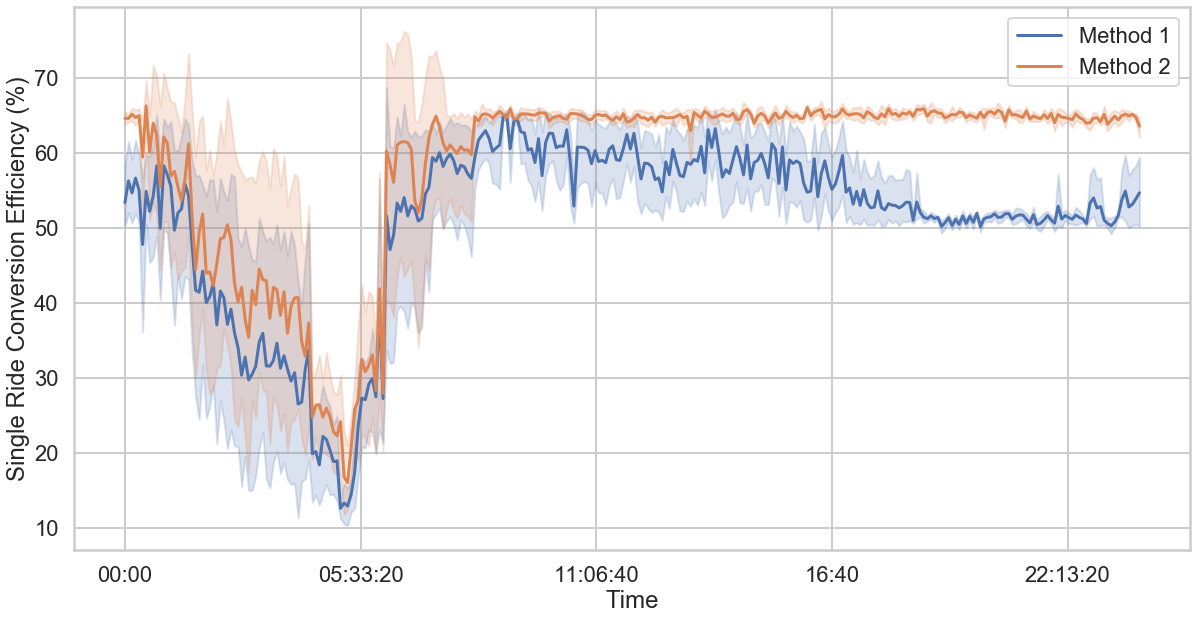

In [47]:
fig = plt.figure(figsize=(20,10))

sns.lineplot(x='Time', y = 'Single Pass Eff M1',  data= summary_df,
             label = 'Method 1')

sns.lineplot(x='Time', y = 'Single Pass Eff M2', data= summary_df,
           label = 'Method 2')

plt.ylabel('Single Ride Conversion Efficiency (%)')

save_fig('Single Ride Conversion Efficiency')

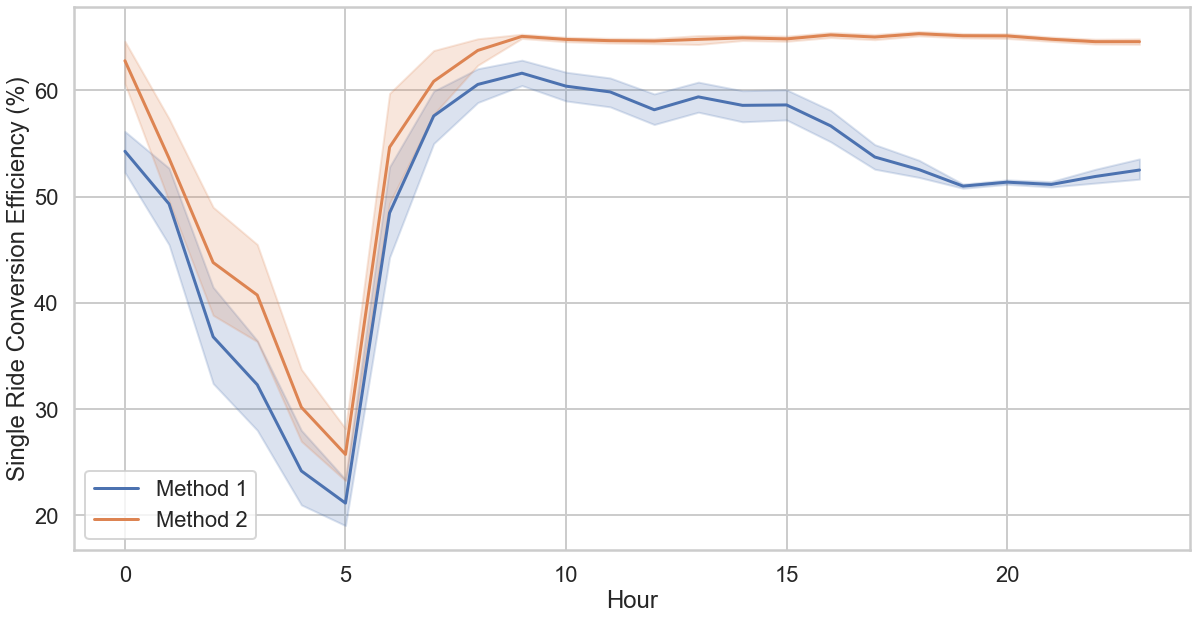

In [48]:
fig = plt.figure(figsize=(20,10))

sns.lineplot(x='Hour', y = 'Single Pass Eff M1',  data= summary_df,
             label = 'Method 1')
sns.lineplot(x='Hour', y = 'Single Pass Eff M2', data= summary_df,
            label = 'Method 2')
plt.ylabel('Single Ride Conversion Efficiency (%)')

save_fig('Single Ride Conversion Efficiency_Hour')

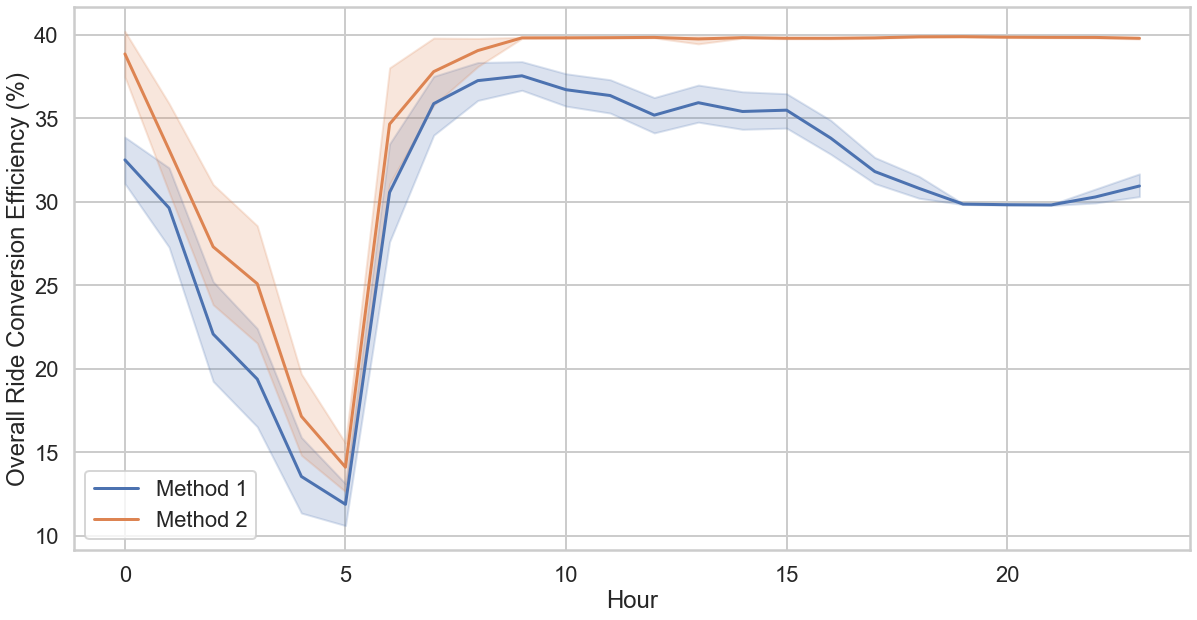

In [49]:
fig = plt.figure(figsize=(20,10))

sns.lineplot(x='Hour', y = 'Trip Red Eff M1',  data= summary_df,
             label = 'Method 1')
sns.lineplot(x='Hour', y = 'Trip Red Eff M2', data= summary_df,
            label = 'Method 2')
plt.ylabel('Overall Ride Conversion Efficiency (%)')

save_fig('Overall Ride Conversion Efficiency_Hour')

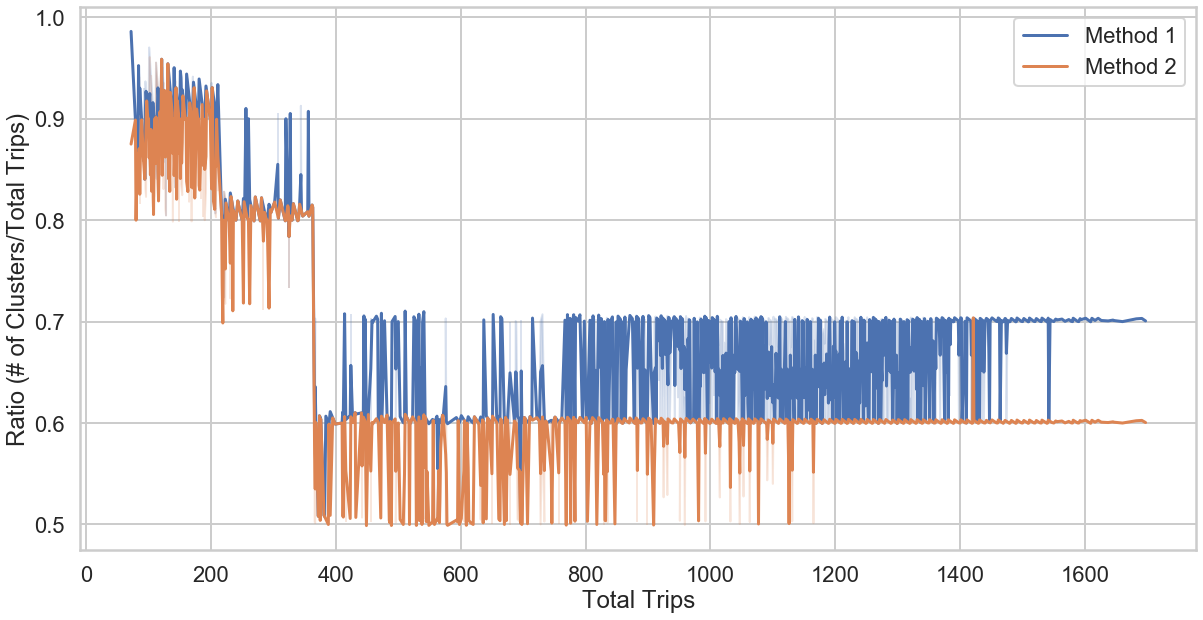

In [50]:
fig = plt.figure(figsize=(20,10))

sns.lineplot(x='Total Trips', 
             y = summary_df['Trips M1']/summary_df['Total Trips'],
             data= summary_df,
             label = 'Method 1')
sns.lineplot(x='Total Trips', 
             y = summary_df['Trips M2']/summary_df['Total Trips'],
             data= summary_df,
             label = 'Method 2')
plt.ylabel('Ratio (# of Clusters/Total Trips)')

save_fig('Ratio of Clusters to Total Trips')

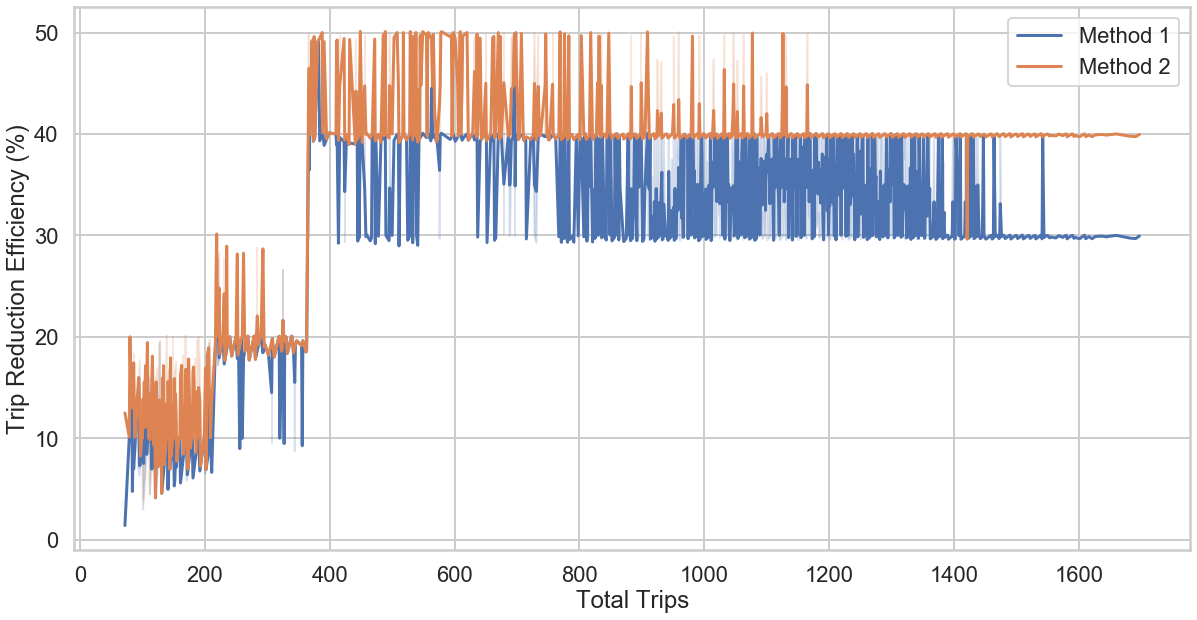

In [51]:
fig = plt.figure(figsize=(20,10))
sns.lineplot(x='Total Trips', y = 'Trip Red Eff M1',  data= summary_df,
             label = 'Method 1')
sns.lineplot(x='Total Trips', y = 'Trip Red Eff M2', data= summary_df,
            label = 'Method 2')
plt.ylabel('Trip Reduction Efficiency (%)')
save_fig('Trip Reduction Efficiency vs Total Trips')

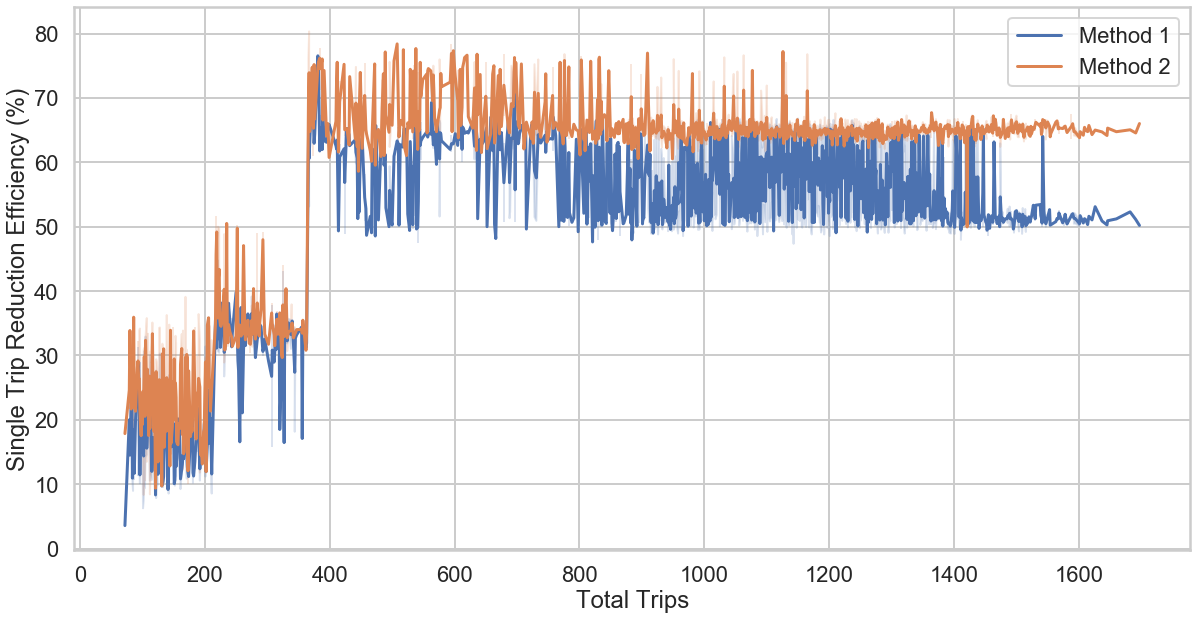

In [52]:
fig = plt.figure(figsize=(20,10))
sns.lineplot(x='Total Trips', y = 'Single Pass Eff M1',  data= summary_df,
             label = 'Method 1')
sns.lineplot(x='Total Trips', y = 'Single Pass Eff M2', data= summary_df,
            label = 'Method 2')
plt.ylabel('Single Trip Reduction Efficiency (%)')

save_fig('Single Trip Reduction Efficiency vs Total Trips')

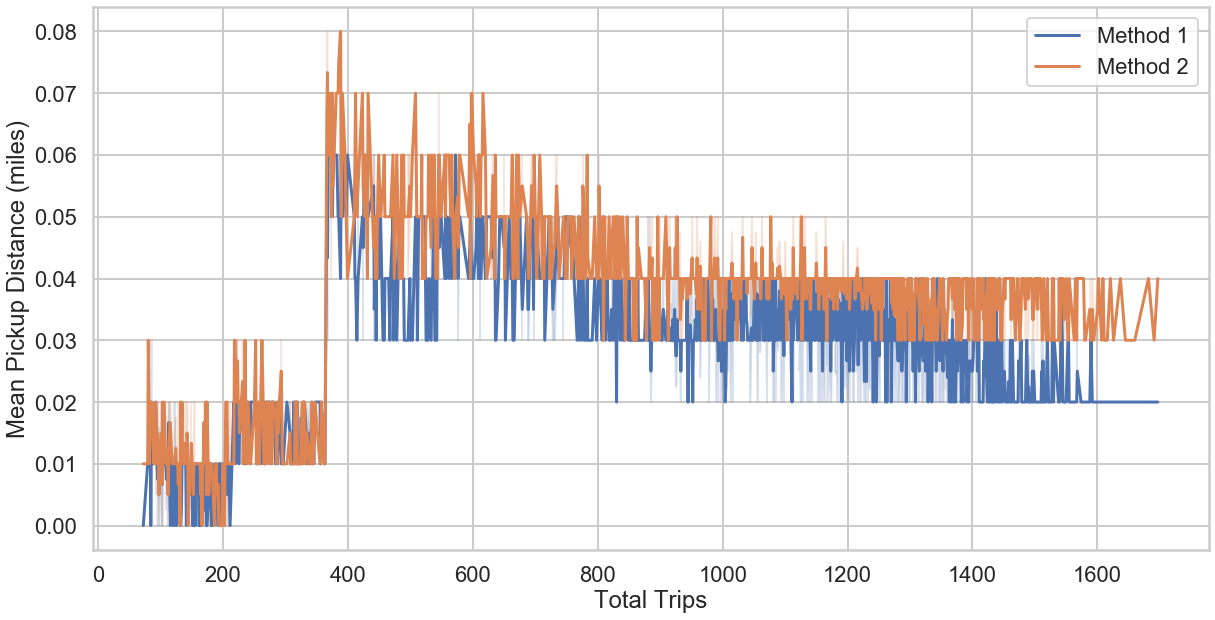

In [53]:
fig = plt.figure(figsize=(20,10))
sns.lineplot(x='Total Trips', y = 'Pickup Dist M1',  data= summary_df,
             label = 'Method 1')
sns.lineplot(x='Total Trips', y = 'Pickup Dist M2', data= summary_df,
            label = 'Method 2')
plt.ylabel('Mean Pickup Distance (miles)')

save_fig('Mean Pickup Distance vs Total Trips')

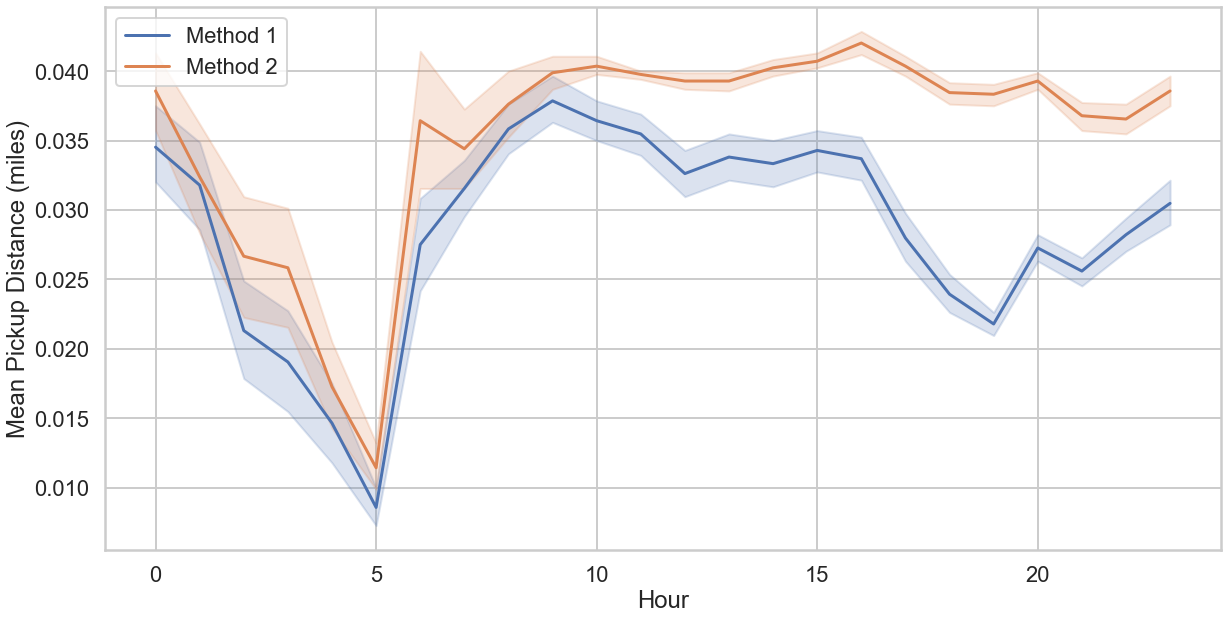

In [54]:
fig = plt.figure(figsize=(20,10))
sns.lineplot(x='Hour', y = 'Pickup Dist M1',  data= summary_df,
             label = 'Method 1')
sns.lineplot(x='Hour', y = 'Pickup Dist M2', data= summary_df,
            label = 'Method 2')
plt.ylabel('Mean Pickup Distance (miles)')

save_fig('Mean Pickup Distance vs Total Trips')

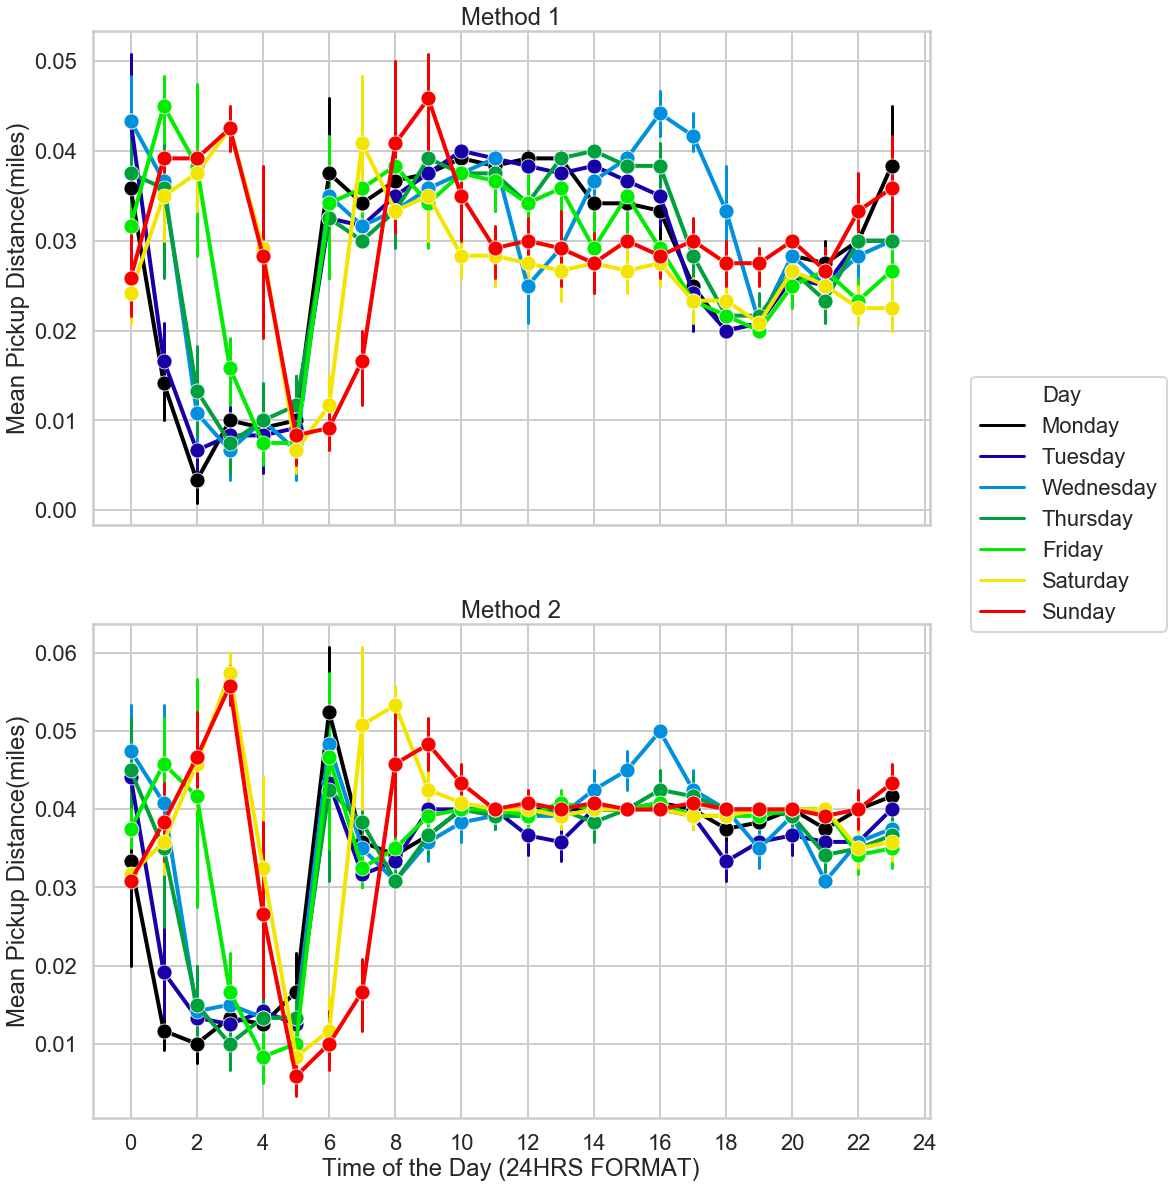

In [55]:
fig, ax = plt.subplots(2,figsize=(15,20), sharex=True)

colors = cm.nipy_spectral(np.linspace(0, 1, summary_df['Day'].nunique()+1))

plot_1 = sns.lineplot(x='Hour', y = 'Pickup Dist M1',palette=colors, linewidth=4,
                      hue='Day' ,marker='o', data= summary_df, ax=ax[0], legend=False,err_style="bars", label= 'Method 1')


plot_2 = sns.lineplot(x='Hour', y = 'Pickup Dist M2',palette=colors, linewidth=4,
                      hue='Day' ,marker='o', data= summary_df,ax=ax[1],err_style="bars")

plt.xlabel(xlabel = 'Time of the Day (24HRS FORMAT)')
plt.legend(bbox_to_anchor=(1.05, 1.5), loc=2, borderaxespad=0.)
plot_1.xaxis.set_major_locator(MultipleLocator(2))
ax[0].set_ylabel('Mean Pickup Distance(miles)')
ax[1].set_ylabel('Mean Pickup Distance(miles)')
ax[0].title.set_text('Method 1')
ax[1].title.set_text('Method 2')
save_fig('Mean Pickup Distance Weekday')

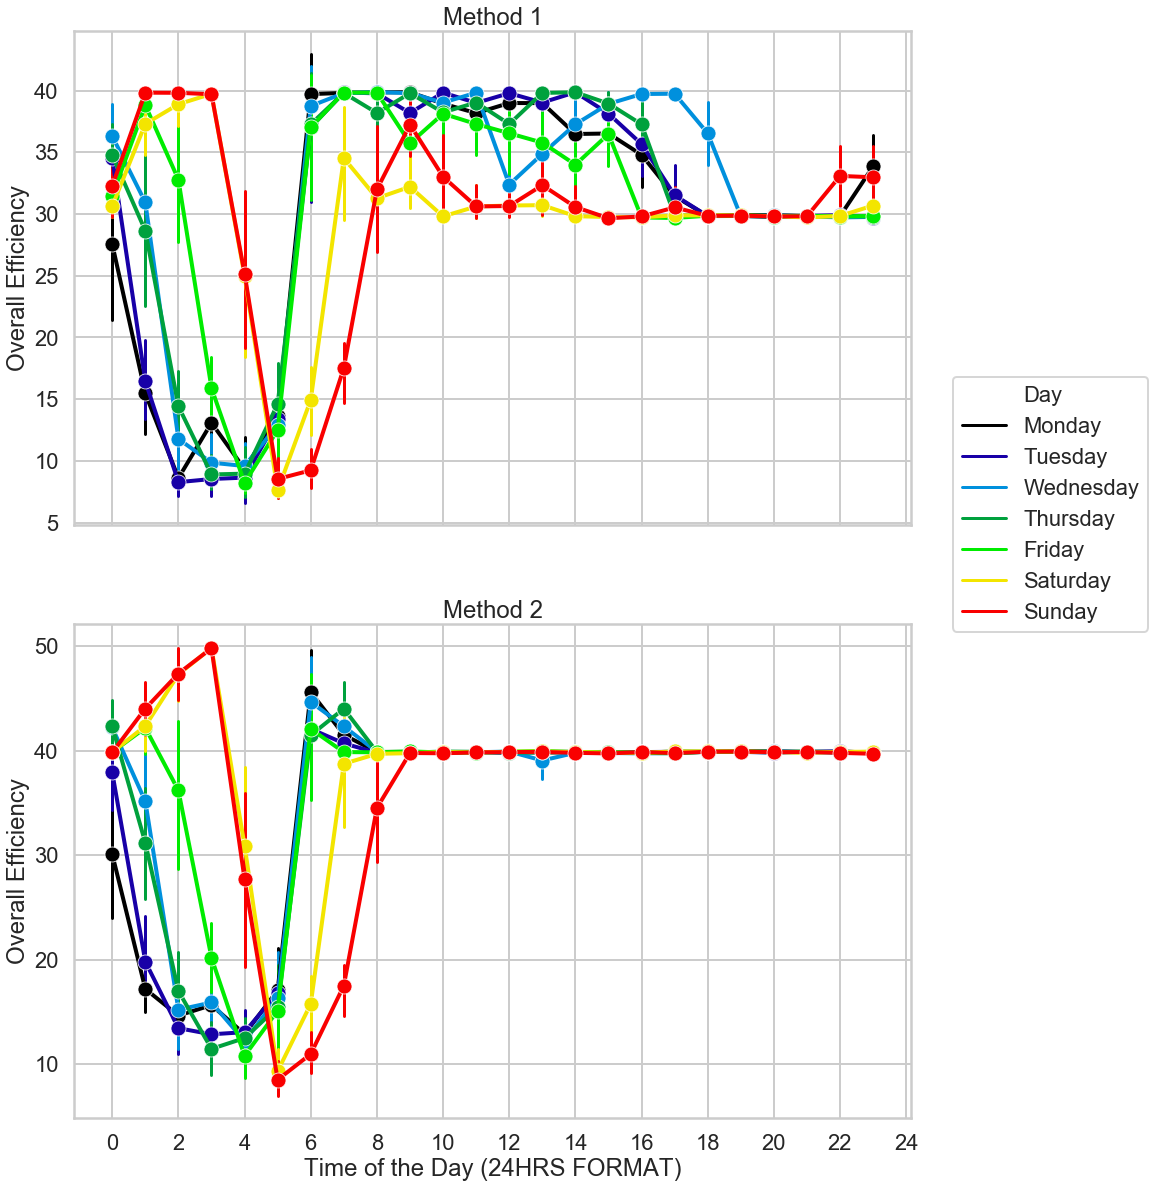

In [56]:
fig, ax = plt.subplots(2,figsize=(15,20), sharex=True)

colors = cm.nipy_spectral(np.linspace(0, 1, summary_df['Day'].nunique()+1))

plot_1 = sns.lineplot(x='Hour', y = 'Trip Red Eff M1',palette=colors, linewidth=4,
                      hue='Day' ,marker='o', data= summary_df, ax=ax[0], legend=False,err_style="bars")
plot_2 = sns.lineplot(x='Hour', y = 'Trip Red Eff M2',palette=colors, linewidth=4,
                      hue='Day' ,marker='o', data= summary_df,ax=ax[1],err_style="bars")

plt.xlabel(xlabel = 'Time of the Day (24HRS FORMAT)')
plt.legend(bbox_to_anchor=(1.05, 1.5), loc=2, borderaxespad=0.)
plot_1.xaxis.set_major_locator(MultipleLocator(2))

ax[0].set_ylabel('Overall Efficiency')
ax[1].set_ylabel('Overall Efficiency')
ax[0].title.set_text('Method 1')
ax[1].title.set_text('Method 2')
save_fig('Overall Efficiency Weekday')

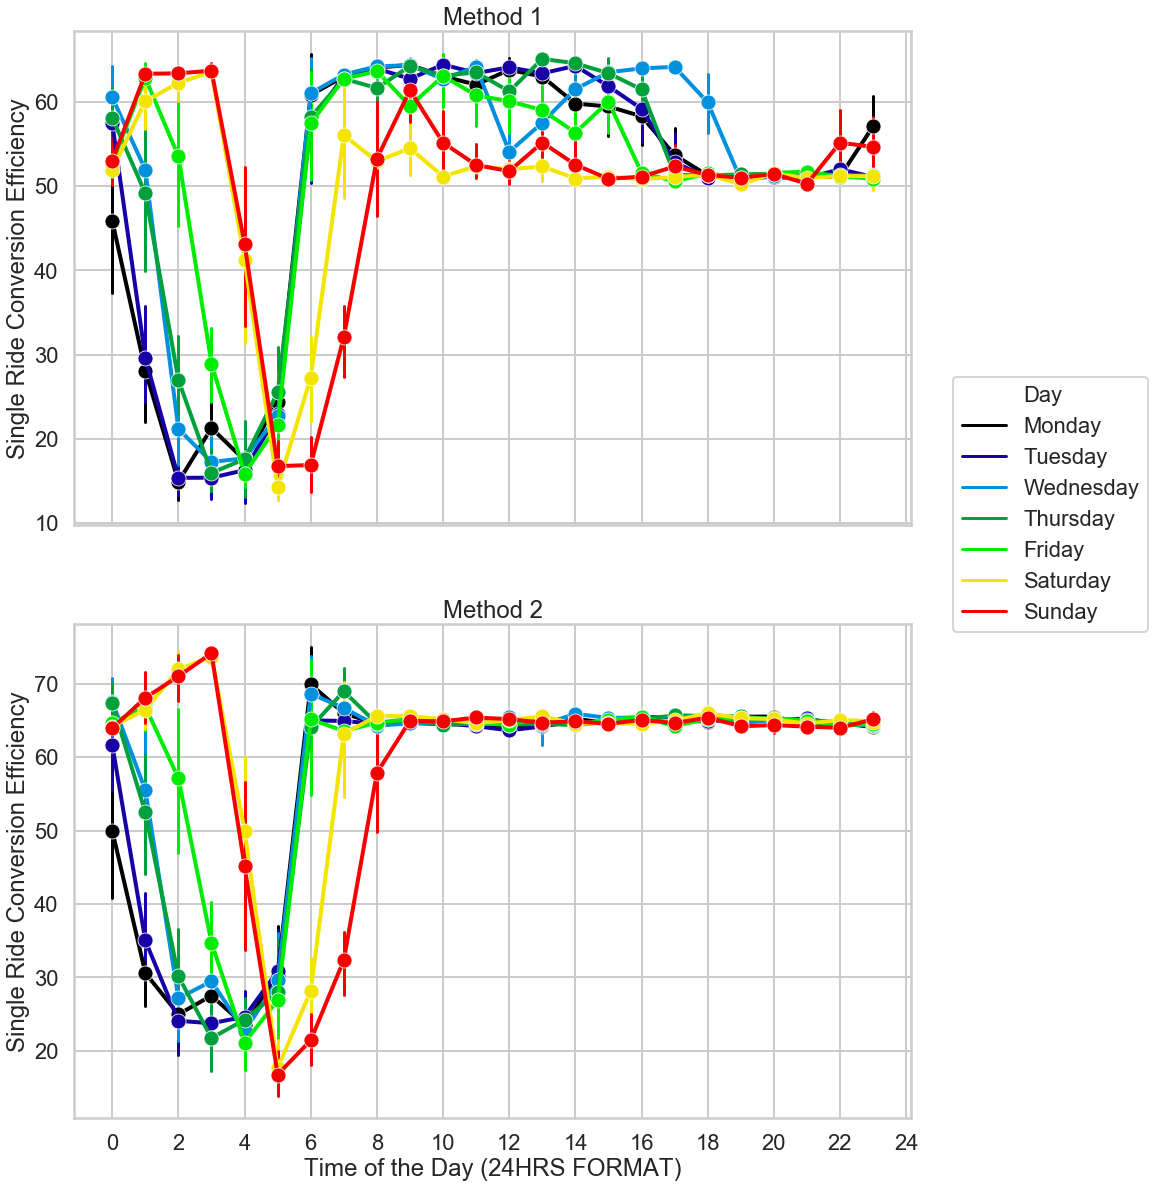

In [57]:
fig, ax = plt.subplots(2,figsize=(15,20), sharex=True)

colors = cm.nipy_spectral(np.linspace(0, 1, summary_df['Day'].nunique()+1))

plot_1 = sns.lineplot(x='Hour', y = 'Single Pass Eff M1',palette=colors, linewidth=4,
                      hue='Day' ,marker='o', data= summary_df, ax=ax[0], legend=False,err_style="bars")
plot_2 = sns.lineplot(x='Hour', y = 'Single Pass Eff M2',palette=colors, linewidth=4,
                      hue='Day' ,marker='o', data= summary_df,ax=ax[1],err_style="bars")

plt.xlabel(xlabel = 'Time of the Day (24HRS FORMAT)')
plt.legend(bbox_to_anchor=(1.05, 1.5), loc=2, borderaxespad=0.)
plot_1.xaxis.set_major_locator(MultipleLocator(2))

ax[0].set_ylabel('Single Ride Conversion Efficiency')
ax[1].set_ylabel('Single Ride Conversion Efficiency')
ax[0].title.set_text('Method 1')
ax[1].title.set_text('Method 2')
save_fig('Single Ride Efficiency Weekday')

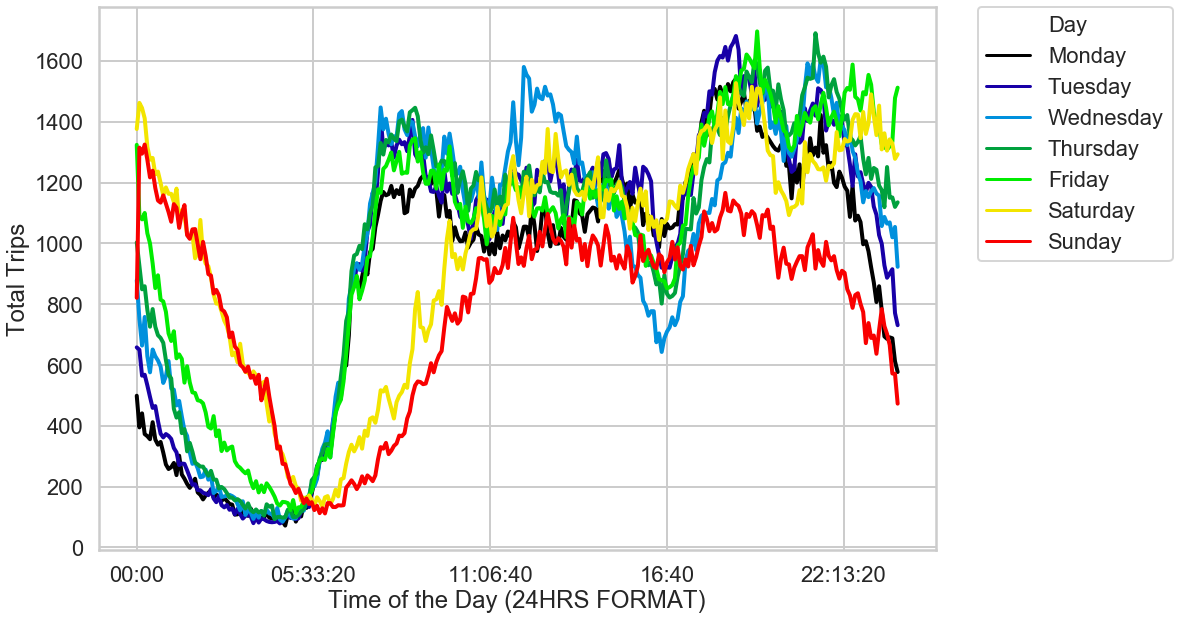

In [58]:
fig = plt.figure(figsize=(15,10))

colors = cm.nipy_spectral(np.linspace(0, 1, summary_df['Day'].nunique()+1))

plot_1 = sns.lineplot(x='Time',hue='Day', y = 'Total Trips',palette=colors, linewidth=4,
                        data= summary_df,err_style="bars")


plt.xlabel(xlabel = 'Time of the Day (24HRS FORMAT)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


In [59]:
def fill_neigh(df):
    geometry=geopandas.points_from_xy(df['Pickup Centroid Longitude'], df['Pickup Centroid Latitude'])
    point = geopandas.GeoDataFrame(df,geometry = geometry )
    poly  = geopandas.GeoDataFrame.from_file('./Boundaries/NYC_NH.shp')
    df_boro = sjoin(point, poly, how='left')
    df['Pickup Neighborhood'] = df_boro['ntaname']
    return df

In [60]:
fname1='./Data/Pickled Data/Cluster DF with Neighborhood_Method 1.pkl'
fname2='./Data/Pickled Data/Cluster DF with Neighborhood_Method 2.pkl'

if path.exists(fname1) and  path.exists(fname2):
    df1_with_neigh = pd.read_pickle(fname1)
    df2_with_neigh = pd.read_pickle(fname2)
else:
    df1_with_neigh = fill_neigh(df1)
    df2_with_neigh = fill_neigh(df2)
    df1_with_neigh.to_pickle(fname1)
    df2_with_neigh.to_pickle(fname2)
df1_with_neigh

,cluster,sum,Count,Pickup Centroid Latitude,Pickup Centroid Longitude,Dropoff Centroid Latitude,Dropoff Centroid Longitude,trips,Passenger Efficiency,Time,Day,Mean Pickup Distance,Mean Dropoff Distance,Hour,geometry,Pickup Neighborhood
715,715,1,1,40.74740,-73.98650,40.73040,-73.98060,1.0,0.0,14:05:00,Saturday,0.00,0.00,14,POINT (-73.98650 40.74740),Midtown-Midtown South
629,629,1,1,40.77500,-73.98070,40.78010,-73.97760,1.0,0.0,21:00:00,Sunday,0.00,0.00,21,POINT (-73.98070 40.77500),Lincoln Square
441,441,2,2,40.73845,-73.99780,40.74150,-73.99545,1.0,50.0,15:40:00,Saturday,0.09,0.13,15,POINT (-73.99780 40.73845),Hudson Yards-Chelsea-Flatiron-Union Square
289,289,1,1,40.77510,-73.94540,40.72620,-74.00170,1.0,0.0,20:30:00,Sunday,0.00,0.00,20,POINT (-73.94540 40.77510),Yorkville
69,69,1,1,40.76040,-74.00290,40.79330,-73.97440,1.0,0.0,12:00:00,Saturday,0.00,0.00,12,POINT (-74.00290 40.76040),Hudson Yards-Chelsea-Flatiron-Union Square
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,349,2,2,40.73130,-73.99245,40.73375,-74.00025,1.0,50.0,10:45:00,Thursday,0.12,0.11,10,POINT (-73.99245 40.73130),West Village
468,468,1,1,40.73660,-73.98490,40.78760,-73.95470,1.0,0.0,18:35:00,Friday,0.00,0.00,18,POINT (-73.98490 40.73660),Gramercy
134,134,5,2,40.72085,-73.99685,40.77945,-73.94770,2.0,0.0,03:40:00,Sunday,0.01,0.17,3,POINT (-73.99685 40.72085),SoHo-TriBeCa-Civic Center-Little Italy
154,154,5,2,40.74695,-73.97970,40.75420,-73.96970,2.0,0.0,03:30:00,Sunday,0.12,0.08,3,POINT (-73.97970 40.74695),Murray Hill-Kips Bay


In [61]:
neighbor_efficiency = df1_with_neigh.groupby(['Pickup Neighborhood'])['Passenger Efficiency'].agg(['mean'])
neighbor_efficiency = neighbor_efficiency.reset_index()

neighborhoods = r'./Boundaries/Neighborhood Tabulation Areas.geojson'

man_cen = [40.7829, -73.9654]
base_map = folium.Map(location=man_cen,zoom_start=12)
base_map.choropleth(geo_data=neighborhoods,
                        data=neighbor_efficiency,
                        key_on='feature.properties.ntaname',
                        columns=['Pickup Neighborhood', 'mean'],
                        fill_color='BuGn', 
                        fill_opacity=.8, 
                        line_opacity=0.8,
                        threshold_scale=[0, 6, 12, 18, 24, 30])
base_map.save('./HTML/Neighborhood_map_Method1.html')
IFrame(src='./HTML/Neighborhood_map_Method1.html', width=900, height=1000)

In [62]:
neighbor_efficiency = df2_with_neigh.groupby(['Pickup Neighborhood'])['Passenger Efficiency'].agg(['mean'])
neighbor_efficiency = neighbor_efficiency.reset_index()
man_cen = [40.7829, -73.9654]
neighborhoods = r'./Boundaries/Neighborhood Tabulation Areas.geojson'
base_map = folium.Map(location=man_cen,zoom_start=12)
base_map.choropleth(geo_data=neighborhoods,
                        data=neighbor_efficiency,
                        key_on='feature.properties.ntaname',
                        columns=['Pickup Neighborhood', 'mean'],
                        fill_color='BuGn', 
                        fill_opacity=.8, 
                        line_opacity=0.8,
                        threshold_scale=[0, 6, 12, 18, 24, 30])
base_map.save('./HTML/Neighborhood_map_Method2.html')
IFrame(src='./HTML/Neighborhood_map_Method2.html', width=900, height=800)